In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import lightgbm as lgb
%matplotlib inline

/Users/jingfeijia/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [23]:
df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')

In [125]:
def get_transforms(df, cat_feas):
    transforms = {}
    for c in cat_feas:
        if c.endswith(('bin', 'cat')):
            tmp = df[[c, 'target']].groupby(c).mean()
            tmp = tmp.sort_values('target').reset_index()
            tmp.loc[:, 'new_'+c] = tmp.index
            del tmp['target']
            transforms[c] = tmp
    return transforms

def apply_transforms(df, transforms):
    df = df.copy()
    for c, tmp in transforms.items():
        if c.endswith(('bin', 'cat')):
            df = df.merge(tmp[[c, 'new_'+c]], on=c)
            df.loc[:, c] = df['new_'+c]
            del df['new_'+c]
            print 'feature {} has been transformed'.format(c)
    return df

In [121]:
df_train = pd.read_csv('../data/train1.csv')
df_test = pd.read_csv('../data/test1.csv')

In [122]:
df_train.columns

Index([u'id', u'target', u'ps_ind_01', u'ps_ind_02_cat', u'ps_ind_03',
       u'ps_ind_04_cat', u'ps_ind_05_cat', u'ps_ind_10_bin', u'ps_ind_11_bin',
       u'ps_ind_12_bin', u'ps_ind_13_bin', u'ps_ind_14', u'ps_ind_15',
       u'ps_reg_01', u'ps_reg_02', u'ps_reg_03', u'ps_car_01_cat',
       u'ps_car_02_cat', u'ps_car_03_cat', u'ps_car_04_cat', u'ps_car_05_cat',
       u'ps_car_06_cat', u'ps_car_07_cat', u'ps_car_08_cat', u'ps_car_09_cat',
       u'ps_car_10_cat', u'ps_car_11_cat', u'ps_car_11', u'ps_car_12',
       u'ps_car_13', u'ps_car_14', u'ps_car_15', u'ps_new_ind_06-09_cat',
       u'ps_new_ind_16-18_cat'],
      dtype='object')

In [123]:
feas_to_drop = [
    'ps_car_02_cat', 
    'ps_car_08_cat', 
    'ps_car_10_cat', 
    'ps_ind_10_bin', 
    'ps_ind_11_bin', 
    'ps_ind_12_bin', 
    'ps_ind_13_bin', 
    'ps_car_11_cat', 
    'ps_ind_14'
]
# feas_to_drop += [c for c in df_train.columns if c.startswith('ps_calc')]

In [124]:
for c in feas_to_drop:
    del df_train[c]
    del df_test[c]

In [7]:
reg_feas = []
cat_feas = []
for c in df_train.columns:
    if c.startswith('ps'):
        if (len(df_train[c].unique()) < 10 or c.endswith(('cat', 'bin'))):
            cat_feas.append(c)
        else:
            reg_feas.append(c)

In [127]:
transforms = get_transforms(df_train, df_train.columns)
df_train = apply_transforms(df_train, transforms)
df_test = apply_transforms(df_test, transforms)

feature ps_car_03_cat has been transformed
feature ps_car_09_cat has been transformed
feature ps_ind_04_cat has been transformed
feature ps_car_06_cat has been transformed
feature ps_car_01_cat has been transformed
feature ps_car_07_cat has been transformed
feature ps_car_04_cat has been transformed
feature ps_ind_05_cat has been transformed
feature ps_car_05_cat has been transformed
feature ps_new_ind_16-18_cat has been transformed
feature ps_new_ind_06-09_cat has been transformed
feature ps_ind_02_cat has been transformed
feature ps_car_03_cat has been transformed
feature ps_car_09_cat has been transformed
feature ps_ind_04_cat has been transformed
feature ps_car_06_cat has been transformed
feature ps_car_01_cat has been transformed
feature ps_car_07_cat has been transformed
feature ps_car_04_cat has been transformed
feature ps_ind_05_cat has been transformed
feature ps_car_05_cat has been transformed
feature ps_new_ind_16-18_cat has been transformed
feature ps_new_ind_06-09_cat has 

In [11]:
# Set xgboost parameters
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.05
params['silent'] = True
params['max_depth'] = 6
params['subsample'] = 0.8
params['colsample_bytree'] = 0.8

# Define the gini metric - from https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703#5897
def gini(actual, pred, cmpcol = 0, sortcol = 1):
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
    
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)
 
def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)

# Create an XGBoost-compatible metric from Gini

def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = gini_normalized(labels, preds)
    return [('gini', gini_score)]


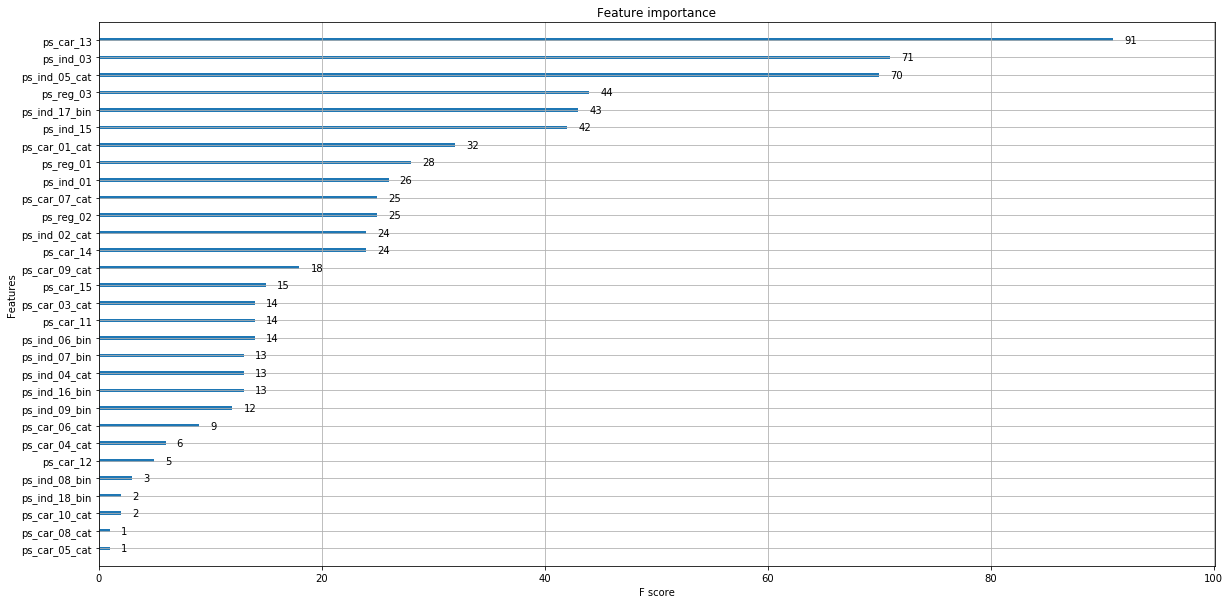

In [110]:
# plot feature importance using built-in function
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot

# fit model no training data
model = XGBClassifier(n_jobs=8)
model.fit(x_train, y_train)
# plot feature importance
fig, ax = plt.subplots(figsize = (20, 10))
plot_importance(model, ax=ax)
pyplot.show()

In [14]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
import xgboost as xgb

In [55]:
df_train = pd.read_csv('../data/train1.csv')
df_test = pd.read_csv('../data/test1.csv')

In [115]:
xgb_preds = []
target_train = df_train['target'].values
id_test = df_test['id'].values

train = np.array(df_train.drop(['target','id'], axis = 1))
test = np.array(df_test.drop(['id'], axis = 1))

In [116]:
K = 5
kf = StratifiedKFold(n_splits = K, random_state = 3228, shuffle = True)

In [128]:
for train_index, test_index in kf.split(train, target_train):
    train_X, valid_X = train[train_index], train[test_index]
    train_y, valid_y = target_train[train_index], target_train[test_index]

    # params configuration also from the1owl's kernel
    # https://www.kaggle.com/the1owl/forza-baseline
    xgb_params = {
        'eta': 0.05, 
        'max_depth': 6, 
        'subsample': 0.8, 
        'colsample_bytree': 0.8, 
        'objective': 'binary:logistic', 
#        'objective': 'rank:pairwise', 
        'eval_metric': 'auc', 
        'seed': 99, 
        'silent': True
    }

    d_train = xgb.DMatrix(train_X, train_y)
    d_valid = xgb.DMatrix(valid_X, valid_y)
    d_test = xgb.DMatrix(test)
    
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]
    model = xgb.train(xgb_params, 
                      d_train, 
                      5000,  
                      watchlist, 
                      feval=gini_xgb, 
                      maximize=True, 
                      verbose_eval=50, 
                      early_stopping_rounds=100)
                        
    xgb_pred = model.predict(d_test)
    xgb_preds.append(list(xgb_pred))


[0]	train-auc:0.602121	valid-auc:0.607716	train-gini:0.205862	valid-gini:0.219673
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
[50]	train-auc:0.650128	valid-auc:0.641899	train-gini:0.300257	valid-gini:0.283798
[100]	train-auc:0.669092	valid-auc:0.646804	train-gini:0.338185	valid-gini:0.293609
[150]	train-auc:0.685341	valid-auc:0.648105	train-gini:0.370681	valid-gini:0.296211
[200]	train-auc:0.699082	valid-auc:0.647504	train-gini:0.398165	valid-gini:0.295007
Stopping. Best iteration:
[143]	train-auc:0.68311	valid-auc:0.648275	train-gini:0.366221	valid-gini:0.29655

[0]	train-auc:0.607714	valid-auc:0.598367	train-gini:0.217285	valid-gini:0.198292
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
[50]	train-auc:0.649916	valid-auc:0.631853	train-gini:0.299831	valid-gini:0.263706
[100]	train-auc:0

In [118]:
preds=[]
for i in range(len(xgb_preds[0])):
    sum=0
    for j in range(K):
        sum+=xgb_preds[j][i]
    preds.append(sum / K)

output = pd.DataFrame({'id': id_test, 'target': preds})
# output.to_csv("Stratified-{}-foldCV_avg_sub.csv".format(K), index=False) 

In [119]:
s = output.target
output.loc[:, 'target'] = (s - s.min()) / (s.max() - s.min()) / 1.1

In [120]:
output.to_csv("Stratified-{}-foldCV_output.csv".format(K), index=False) 

In [125]:
cols = np.array(xgb_preds)

In [126]:
df = pd.DataFrame(data = cols.T)

In [109]:
columns = {i:'col_{}'.format(i) for i in range(10)}

In [110]:
df = df.rename(columns=columns)

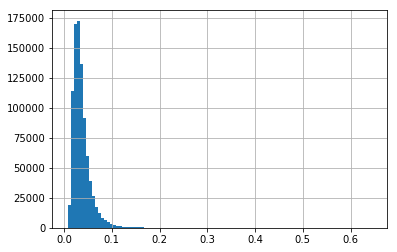

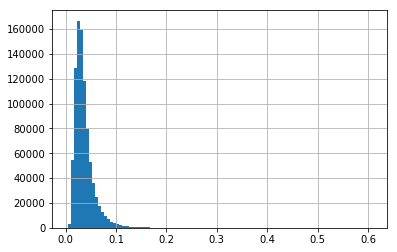

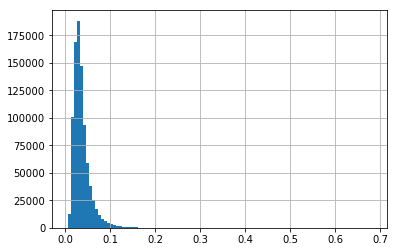

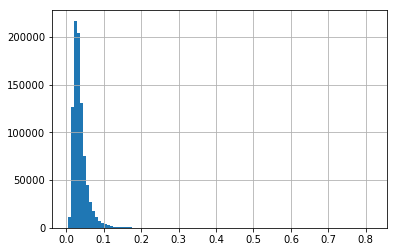

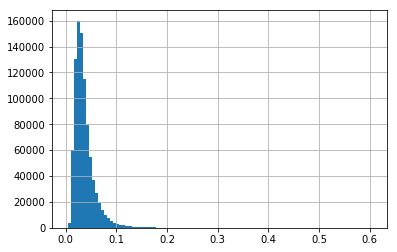

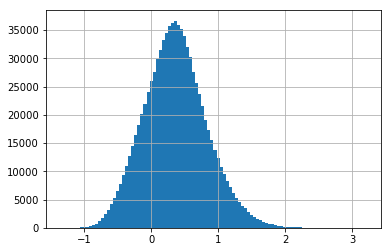

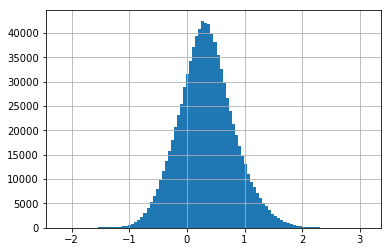

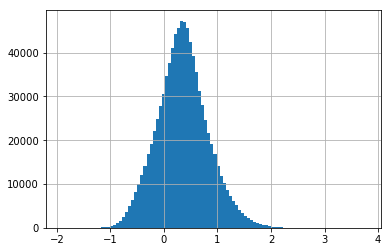

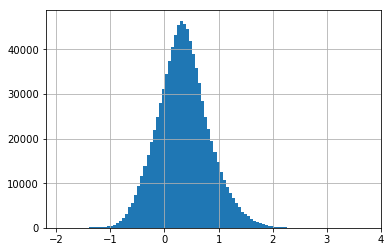

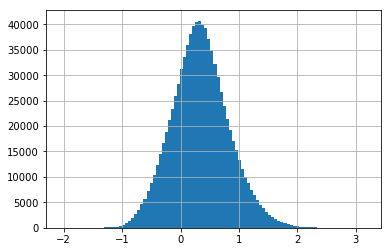

In [111]:
for c in df.columns:
    df[c].hist(bins=100)
    plt.show()

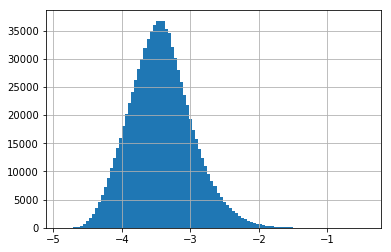

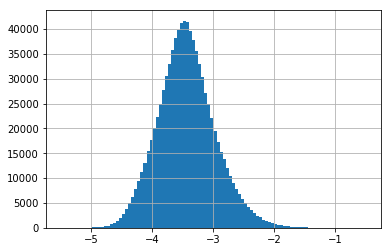

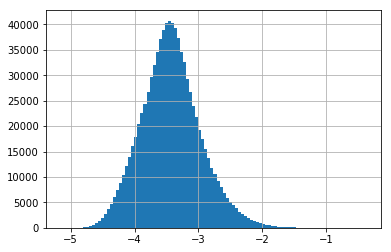

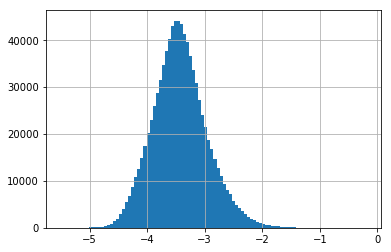

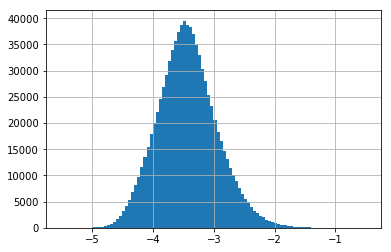

/Users/jingfeijia/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app


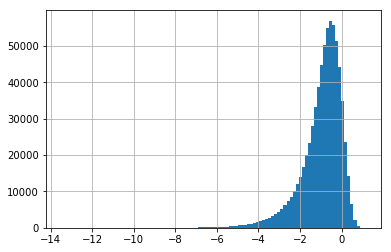

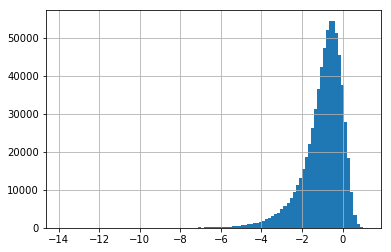

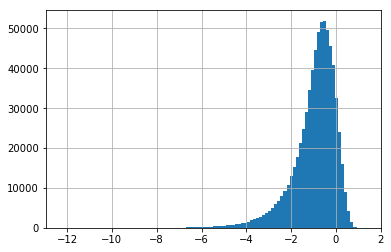

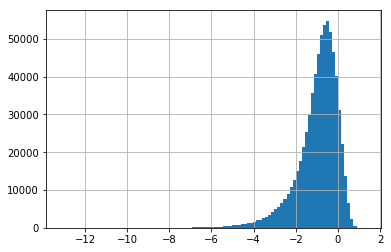

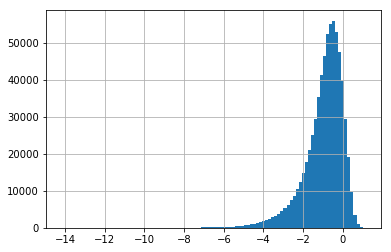

In [73]:
for c in df.columns:
    np.log(df[c]).hist(bins=100)
    plt.show()

In [127]:
df1 = df[df.columns[:5]]

In [113]:
df2 = df[df.columns[5:]]

In [78]:
df2.shape

(892816, 5)

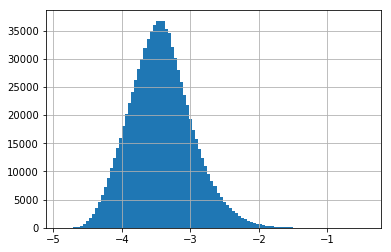

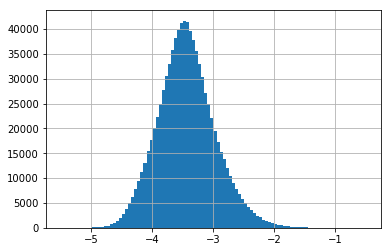

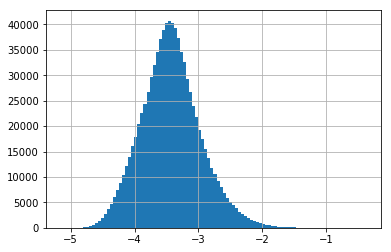

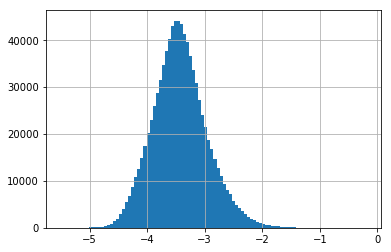

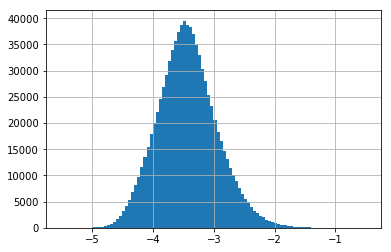

In [118]:
for c in df1.columns:
    df1[c].hist(bins=100)
    plt.show()

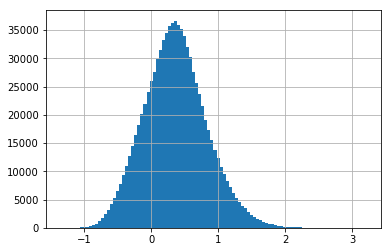

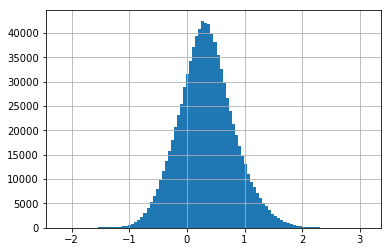

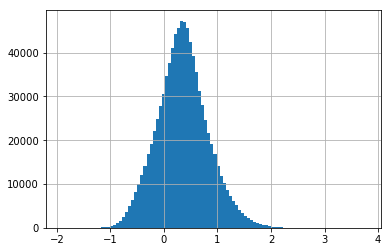

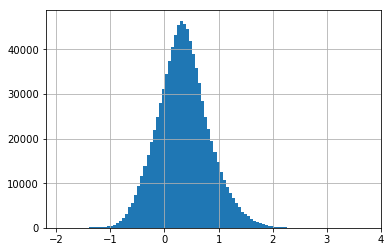

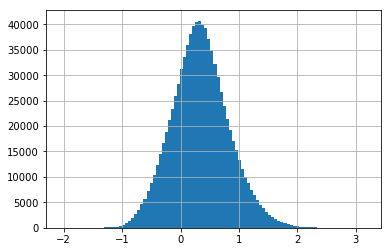

In [119]:
for c in df2.columns:
    df2[c].hist(bins=100)
    plt.show()

In [117]:
df1 = np.log(df1)

In [120]:
output = pd.DataFrame({'id': id_test, 'target': df2.sum(axis=1) + df1.sum(axis=1)})

In [86]:
df1.to_csv('df1.csv', index=False)
df2.to_csv('df2.csv', index=False)

In [121]:
output.loc[:, 'target'] = (output.target - output.target.min()) / (output.target.max() - output.target.min()) / 1.1

In [137]:
output.to_csv('./output.csv', index=False)

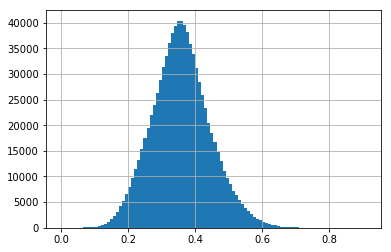

In [93]:
output.target.hist(bins=100)

In [94]:
for c in df1.columns:
    df1.loc[:,c] = np.log(df1[c]) - np.log(df1[c]).mean()

/Users/jingfeijia/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:601: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/Users/jingfeijia/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [96]:
df1.shape, df1.dropna().shape

((892816, 5), (892816, 5))

In [97]:
output = pd.DataFrame({'id': id_test, 'target': df1.mean(axis=1)})

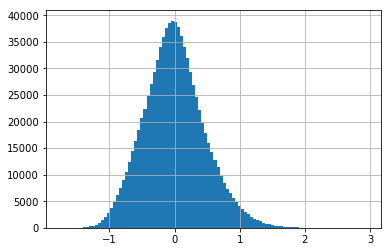

In [98]:
output.target.hist(bins=100)

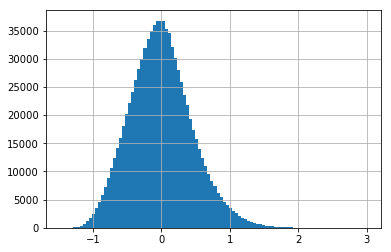

In [102]:
df1.col_0.hist(bins=100)

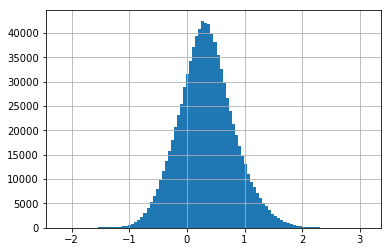

In [104]:
df2.col_6.hist(bins=100)

In [105]:
df2.col_5.std()

0.46722668409347534

In [133]:
df1.loc[:, 'p'] = 1
df1.loc[:, 'q'] = 1
for i in range(5):
    df1.loc[:, 'p'] *= df1[i]
    df1.loc[:, 'q'] *= (1 - df1[i])

In [134]:
output.loc[:, 'target'] = df1.p / (df1.p + df1.q)

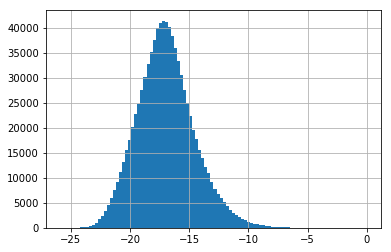

In [136]:
np.log(output.target).hist(bins=100)